# Test how the stop iteration of rlgc deconvolution is affected by the refractive index of sample.   Also look at the resulting AXIAL shape of deconvoluton of a high SNR bead image

  
  Refractive index of the sample is an important parameter when calculating theoretical PSFs. In this notebook I test how the value used for refractive index of the sample effect the stopping point of rlgc deconvolution of a high SNR widefield bead image.  The sample is a bead of known radius 2.5 um from the EPFL BIG lab and can be found [here](http://bigwww.epfl.ch/deconvolution/bead/).  I want to determine how many iterations Richardson Lucy will continue to 'improve' for.  I also want to investigate if the PSF used changes the optimal number of iterations (for example will artifacts appear earlier if a slightly mismatched PSF is used.) 

## Note on Visualizations 

  3D Deconvolution of most microscopy modalities should always be evaluated by looking at 3D Orthogonal views or looking at the reconstructed objects in a 3D viewer.  In this notebook the visualizations are all of zy slices.  Aberrations effect the axial (z) appearance of the object more than the xy, so the restorations are visualized in the zy plane in order to evaluate the axial shape of the bead. 

  ## Some meta data considerations

  In order to deal with refractive index mismatch the z-location at which to calculate the PSF must be determined (Assuming stationary (non-varying) PSF).  A good assumption is to calculate it at the center slice (if the sample is roughly centered).  However there are 2 potential complications.  The first slice of the image may not be at the coverslip, thus the position of the first slice needs to be known.  It is also possible that the slice closest to the coverslip can be at the top or bottom of the digital image.  One needs to be careful that the orientation of the image (whether depth is increasing towards the top or bottom) is consistent with how depth is defined in the PSF.  

## Disclaimer

This notebook is based on code from my own personal repository where I store useful code snippets and examples.  I've organized the repository into namespaces and modules, some of which I find very useful for prototyping, however the code-base is always a work in progress, depending on the problems I am working any given week, so there could be bugs, if so let me know.

## Assumptions

I assume the bead is apr. 20 microns from the coverslip based on the dimensions of the original image and the spacings.  I also assume the main cause of SA is the mismatch between the Oil and the substance that the bead is embedded in (assume that the coverslip and oil are matched.).  I am not a microscopist so happy to learn of better assumptions. 

Potential Improvements:  THe PSFs are generated with a Gibson Lanni implementation.  Perhaps even better results could be obtained with a vectorial model, and accounting for additional mismatch because of the coverslip. 

A non-variable PSF is used.  Further improvements could be obtained by using a variable PSF (because in reality the PSF will change as a function of depth).


## Load the test image

Load the test image and crop the image a bit as to speed up testing.  We also reverse the z axis of the stack so that it is consistent with positive 'depth' being below the coverslip.

size of bead image:  (256, 256, 256)
size of cropped bead image:  (50, 256, 256)


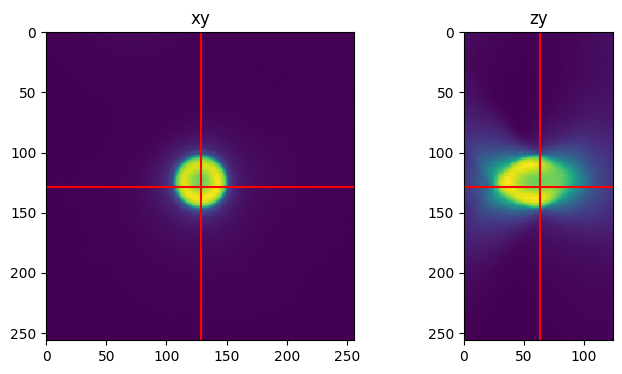

In [1]:
from skimage.io import imread
import numpy as np
from tnia.plotting.projections import show_xy_zy_slice

path_=r"D:\images\tnia-python-images\deconvolution\bead"

bead=imread(path_+"/Bead.tif")
print('size of bead image: ',bead.shape)
z_start=75
z_end=125
z_to_view=(z_end-z_start)//2

# define the region of interest to speed up the processing
roi=np.s_[z_start:z_end, :, :]
bead=bead[roi]
bead=bead[::-1,:,:]
print('size of cropped bead image: ',bead.shape)
xy_spacing = 0.0645
z_spacing=.16

ratio = z_spacing/xy_spacing

fig=show_xy_zy_slice(bead,128,128,z_to_view, sz=ratio, figsize=(8,4))

## Generate PSFs at different specimen refractive indexes.

Here we generate multiple PSFs.  The meta data does not include the refractive index of the medium the bead is embedded in.  It is likely close to, but not exactly the refractive index of the lens immersion media, thus we try different values between 1.4 and 1.52

sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected
sdeconv 1.x.x detected


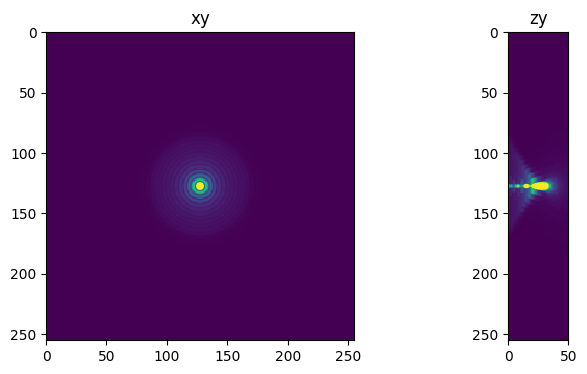

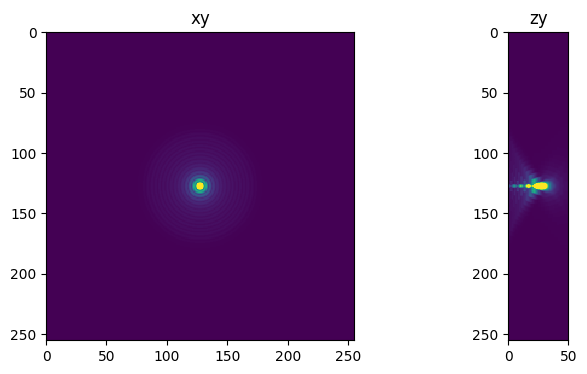

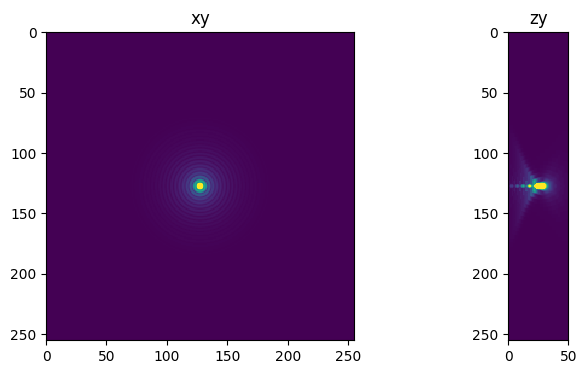

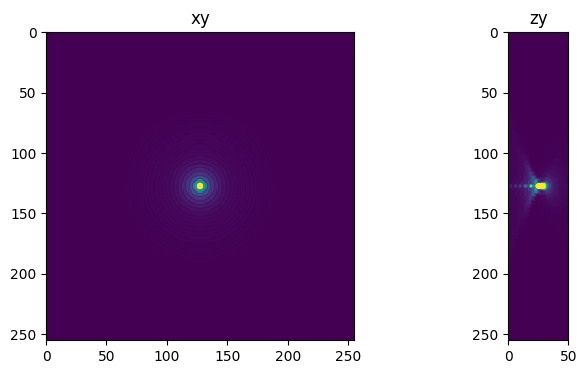

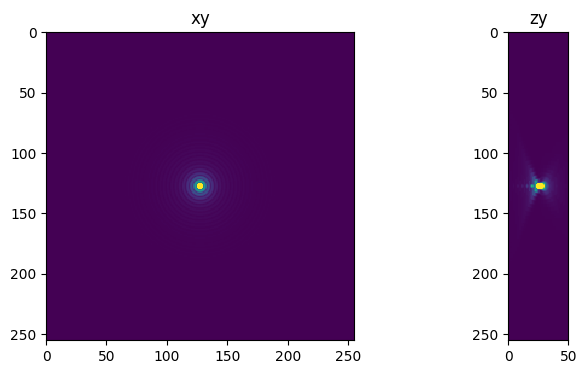

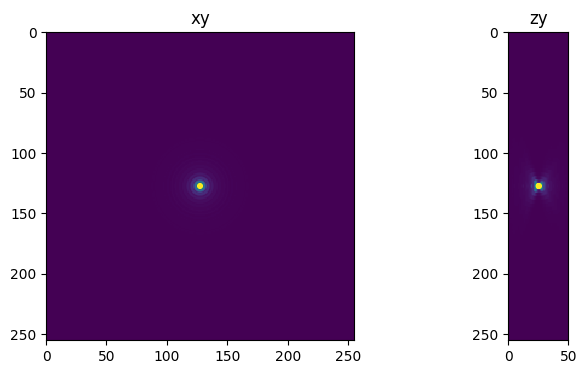

In [41]:
from tnia.nd.ndutil import centercrop
from tnia.deconvolution.psfs import gibson_lanni_3D
from tnia.plotting.projections import show_xy_zy_max
from tnia.deconvolution.psfs import recenter_psf_axial
from skimage.io import imsave

ni=1.518
ns=1.48
ns_to_test=[1.38, 1.42, 1.45, 1.47, 1.49, 1.51]
NA=1.4
w=0.530

xy_spacing = 0.0645
z_spacing=.16

xy_psf_dim=255
z_compute_psf_dim=599
z_crop_psf_dim=50

#depth to compute PSF at
d=128*z_spacing

psfs=[]
for ns in ns_to_test:

    psf  = gibson_lanni_3D(NA, ni, ns, xy_spacing, z_spacing, xy_psf_dim, z_compute_psf_dim, d, w)
    psf = psf.astype('float32')

    #fig=show_xy_zy_max(psf, vmax=psf.max())
    psf=recenter_psf_axial(psf, z_crop_psf_dim)
    #psf,labels=recenter_psf_axial(psf, 255, return_labels=True)
    #fig=show_xy_zy_max(labels)
    fig=show_xy_zy_max(psf, vmax=psf.max()/4, figsize=(8,4))
    psfs.append(psf)
    
#imsave(path_+"/PSF-SA.tif", psf)

## Run deconvolution with rlgc

In [58]:
max_iterations=1000

In [ ]:
from richardson_lucy_gradient_consensus_2025_06_22 import rlgc_latest
from clij2fft.richardson_lucy import richardson_lucy
from skimage.filters import threshold_otsu

global_threshold = threshold_otsu(bead)
bead_otsu = bead > global_threshold

recons=[]
best_recons=[]
stats=[]
stop_iterations=[]
otsus = []
best_otsus = []
rl_1000s = []
rltv_1000s = []

max_iterations = 1000

for psf in psfs:
    recon, best_recon, stat, stop_iteration = rlgc_latest(bead, psf, max_iterations, False)
    recons.append(recon)
    best_recons.append(best_recon)
    stats.append(stat)
    stop_iterations.append(stop_iteration) 

    t = threshold_otsu(recon)
    otsu = recon > t
    otsus.append(otsu)

    t = threshold_otsu(best_recon)
    best_otsu = best_recon > t
    best_otsus.append(best_otsu)

    rl_1000 = richardson_lucy(bead, psf, max_iterations)
    rl_1000s.append(rl_1000)

    rltv_1000 = richardson_lucy(bead, psf, max_iterations, 0.0001)
    rltv_1000s.append(rltv_1000)

Iteration 001 completed in 0.307 s. KLDs = 0.1440 (image), 0.1460 (split 1), 0.1460 (split 2). Update range: 0.69 to 5.04. Largest relative delta = 0.80168.
Iteration 002 completed in 0.037 s. KLDs = 0.0484 (image), 0.0502 (split 1), 0.0501 (split 2). Update range: 0.86 to 1.89. Largest relative delta = 0.47087.
Iteration 003 completed in 0.035 s. KLDs = 0.0305 (image), 0.0322 (split 1), 0.0322 (split 2). Update range: 0.87 to 1.38. Largest relative delta = 0.27594.
Iteration 004 completed in 0.035 s. KLDs = 0.0251 (image), 0.0268 (split 1), 0.0268 (split 2). Update range: 0.89 to 1.23. Largest relative delta = 0.18497.
Iteration 005 completed in 0.035 s. KLDs = 0.0223 (image), 0.0240 (split 1), 0.0240 (split 2). Update range: 0.90 to 1.17. Largest relative delta = 0.13952.
Iteration 006 completed in 0.033 s. KLDs = 0.0205 (image), 0.0221 (split 1), 0.0221 (split 2). Update range: 0.92 to 1.13. Largest relative delta = 0.11279.
Iteration 007 completed in 0.032 s. KLDs = 0.0191 (image),

In [46]:
stop_iterations

[307, 303, 303, 307, 303, 270]

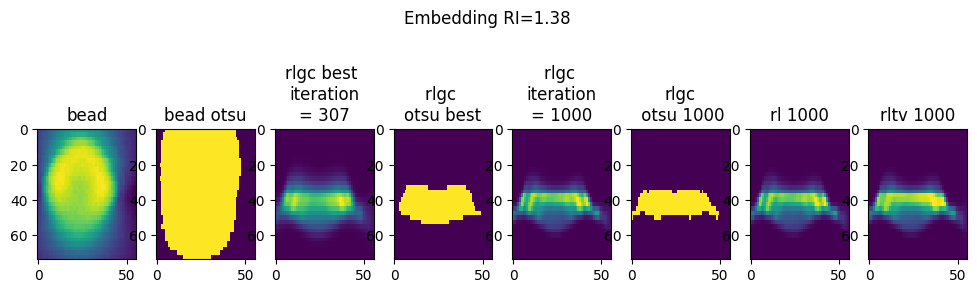

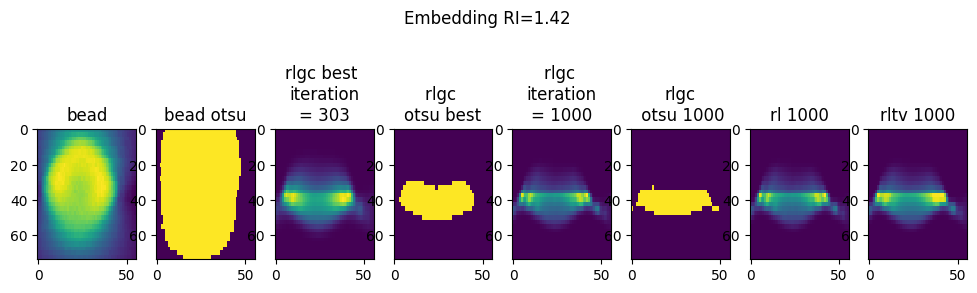

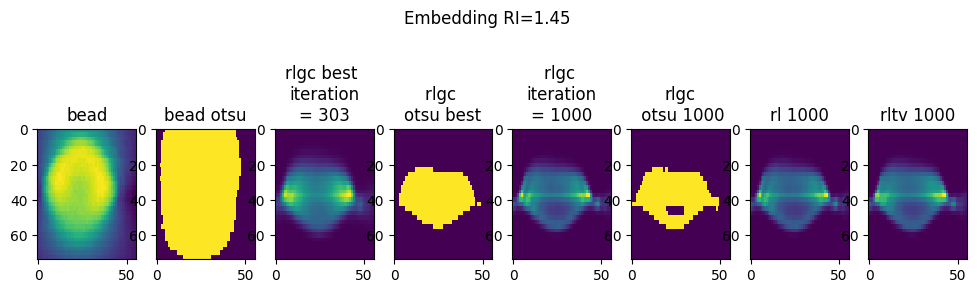

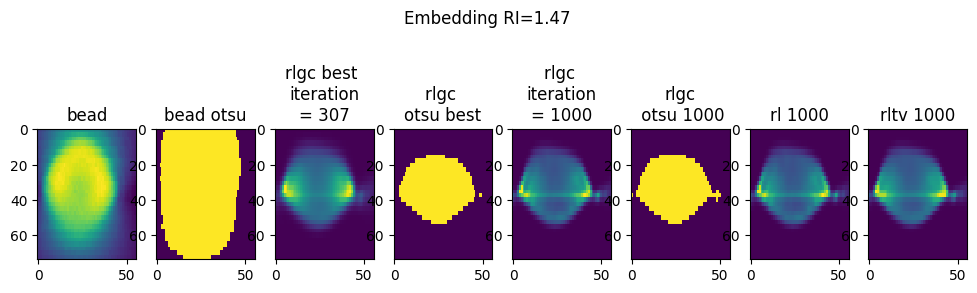

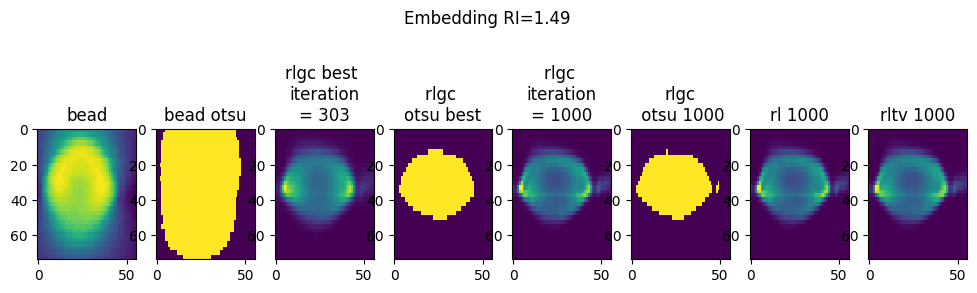

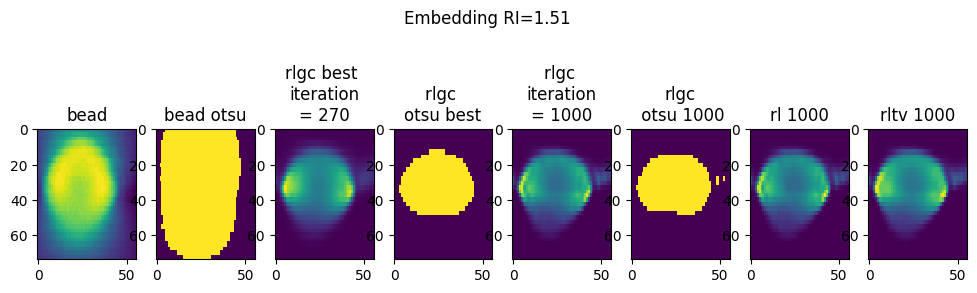

In [65]:
from tnia.plotting.plt_helper import imshow_multi2d
from skimage.transform import resize
decons_=[]
titles = []
ind = np.s_[10:40, 100:156, 120]

#decons = [[best_recon, recon]]
#otsus = [[best_otsu, otsu]]
#ns_to_test = [1.42, .142]

bead_=bead[ind]
bead_ = resize(bead_, (int(bead_.shape[0]*ratio), bead_.shape[1]), anti_aliasing=False, preserve_range=True, order=0)

bead_otsu_ = bead_otsu[ind]
bead_otsu_ = resize(bead_otsu_, (int(bead_otsu_.shape[0]*ratio), bead_otsu_.shape[1]), anti_aliasing=False, preserve_range=True, order=0)

i=0
#for i in range(len(recons)):
for i, ns in enumerate(ns_to_test):
    #for decon, otsu in zip(decons[i], otsus[i]):
    #fig=show_xy_zy_slice(decon,128,128,25, sz=ratio)
    #fig.suptitle('decon ns='+str(ns))
    decons_=[]
    titles = []
    
    decons_.append(bead_)
    titles.append('bead')
    decons_.append(bead_otsu_)
    titles.append('bead otsu')
    
    temp = best_recons[i][ind]
    temp = resize(temp, (int(temp.shape[0]*ratio), temp.shape[1]), anti_aliasing=False, preserve_range=True, order=0)
    decons_.append(temp)

    temp = best_otsus[i][ind]
    temp = resize(temp, (int(temp.shape[0]*ratio), temp.shape[1]), anti_aliasing=False, preserve_range=True, order=0)
    decons_.append(temp)
    
    temp = recons[i][ind]
    temp = resize(temp, (int(temp.shape[0]*ratio), temp.shape[1]), anti_aliasing=False, preserve_range=True, order=0)
    decons_.append(temp)

    temp = otsus[i][ind]
    temp = resize(temp, (int(temp.shape[0]*ratio), temp.shape[1]), anti_aliasing=False, preserve_range=True, order=0)
    decons_.append(temp)

    temp = rl_1000s[i][ind]
    temp = resize(temp, (int(temp.shape[0]*ratio), temp.shape[1]), anti_aliasing=False, preserve_range=True, order=0)
    decons_.append(temp)

    temp = rltv_1000s[i][ind]
    temp = resize(temp, (int(temp.shape[0]*ratio), temp.shape[1]), anti_aliasing=False, preserve_range=True, order=0)
    decons_.append(temp)
                                                             
    titles.append(f'rlgc best \niteration\n= {stop_iterations[i]}')
    titles.append(f'rlgc \notsu best')
    titles.append(f'rlgc \niteration\n= {max_iterations}')
    titles.append(f'rlgc\n otsu {max_iterations}')
    titles.append(f'rl {max_iterations}')
    titles.append(f'rltv {max_iterations}')

    fig = imshow_multi2d(decons_, titles, 1, 8, 12, 3.8)
    fig.suptitle('Embedding RI='+str(ns))
    